**ECL Modeling - Run Regression** <br><br>_Required library: pandas, numpy, scipy, sklearn, itertools, statsmodels, matplotlib_

In [138]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import matplotlib.pyplot as plt
from random import random, seed
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
import itertools
import time
from functools import lru_cache

t_start = time.time()

In [89]:
def interpolation(x, type:str = 'linear'):
    return x.interpolate(method=type)

**Setup Model Arguments**

In [97]:
model_args = {
    'BASE' : "C:\\Users\\muhammad.huda\\Documents\\python\\python_scripts\\file\\input\\model_Q124"
    ,'OUTPUT' : "C:\\Users\\muhammad.huda\\Documents\\python\\python_scripts\\file\\input\\model_Q124\\output"
    ,'MEV_DATA' : "MEV_GDP.csv"
}

**Data load Macroeconomic variable**

In [121]:
x_mev = pd.read_csv(Path().joinpath(model_args['BASE'], model_args['MEV_DATA']),sep=",",decimal=".", index_col=['Date'],parse_dates=["Date"]).asfreq("M")
x_mev.index = x_mev.index.to_period("M").to_timestamp("M")
x_mev = x_mev.copy().apply(interpolation, type='time')

**Examine the white noise data**

In [126]:
size =int(len(x_mev) * 0.8)
x_mev, x_mev_test = x_mev.iloc[:size], x_mev.iloc[size:]
wn = np.random.normal(loc=x_mev['PX_LAST'].mean(), scale=x_mev['PX_LAST'].std(), size=len(x_mev['PX_LAST']))
x_mev['wn'] = wn

**Examine Random Walk**

In [136]:
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    val = random_walk[i-1] + movement
    random_walk.append(val)
    
# pd.plotting.autocorrelation_plot(random_walk)
# plt.show()

ADF Statistic: 0.341605
p-value: 0.979175
Critical value: 
	1%: -3.437
	5%: -2.864
	10%: -2.568


**Stationarity Check**

In [139]:
stationary_check = adfuller(x_mev['PX_LAST'])
print("ADF Statistic: %F" % stationary_check[0])
print("p-value: %F" % stationary_check[1])
print("Critical value: ")
for k, v in stationary_check[4].items():
    print('\t%s: %.3F' % (k, v))


ADF Statistic: -3.849066
p-value: 0.002443
Critical value: 
	1%: -3.465
	5%: -2.877
	10%: -2.575


**Seasonality Plot**

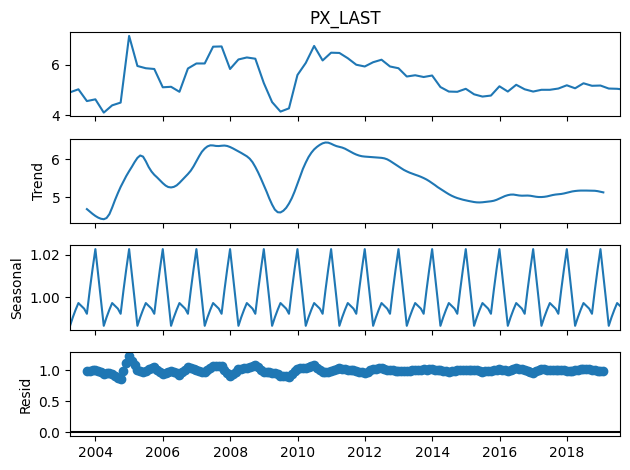

In [141]:
s_dec_additive = seasonal_decompose(x_mev['PX_LAST'], model='multiplicative')
s_dec_additive.plot()
plt.show()

**ACF Testing**

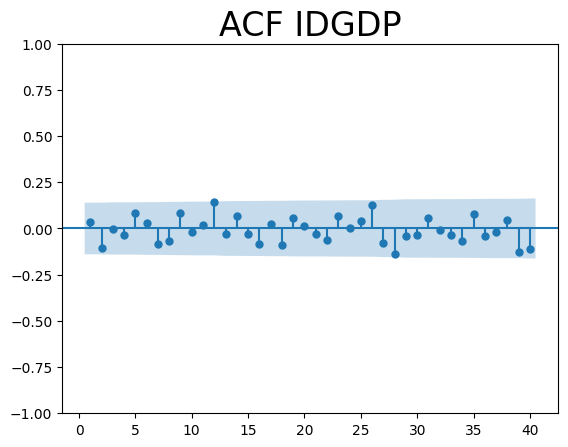

In [150]:
sgt.plot_acf(x_mev['wn'], lags=40, zero=False)
plt.title("ACF IDGDP", size=24)
plt.show()

**PACF Testing**

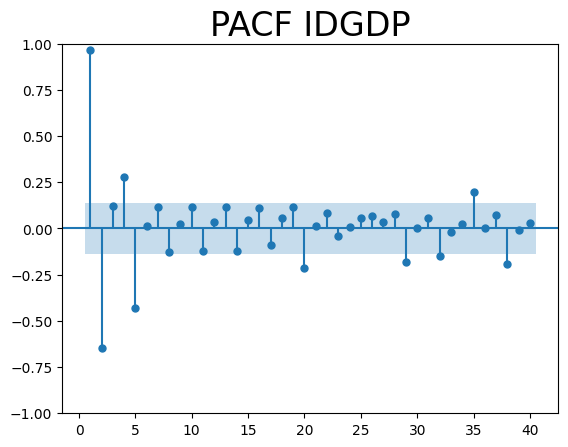

In [154]:
sgt.plot_pacf(x_mev['PX_LAST'], lags=40, zero=False, method=('ols'))
plt.title("PACF IDGDP", size=24)
plt.show()